## Import required libraries

In [1]:
import pandas as pd
import numpy as np

import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, ndcg_score

import xgboost as xgb

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../data/clean_train.csv')
test_df = pd.read_csv('../data/clean_test.csv')

## Load and prepare data for training

In [3]:
df = train_df

df['date_time'] = pd.to_datetime(df['date_time'])
df['month'] = df['date_time'].dt.month
df = df.drop(columns=['date_time'])

df['relevance'] = df.apply(lambda x: 5 if x['booking_bool'] else (1 if x['click_bool'] else 0), axis=1)

X = df.drop(columns=['booking_bool', 'click_bool', 'relevance'])  # Features (exclude target and relevance score)
y = df['relevance']  # Relevance score as the target

groups = df['srch_id']


# GroupShuffleSplit (70% train, 30% eval) - ensuring same 'srch_id' stays in the same split
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Get train and validation split
for train_index, val_index in gss.split(X, y, groups=groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# Optional: Check group sizes
train_groups = X_train.groupby('srch_id').size()
val_groups = X_val.groupby('srch_id').size()

## Build & Train Model

In [4]:
# Initialize XGBoost ranker
ranker = xgb.XGBRanker(
    objective='rank:ndcg',
    eval_metric='ndcg@5',
    random_state=65,
    n_estimators=400,
    learning_rate=0.1,
    tree_method='hist',  # XGBoost's histogram-based method for faster training

    # Tree structure parameters
    max_depth=4,  # Reduced from 6 to limit tree complexity
    min_child_weight=3,  # Increased from 1 to make splits more conservative
    subsample=0.7,  # Reduced from 0.8 to use fewer samples per tree
    colsample_bytree=0.7,  # Reduced from 0.8 to use fewer features per tree
    
    # Regularization parameters
    reg_alpha=1.0,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    gamma=0.1  # Minimum loss reduction required for a split
)

# Create DMatrix for training and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set group information
dtrain.set_group(train_groups)
dval.set_group(val_groups)

# Train the model
ranker.fit(
    X_train,
    y_train,
    group=train_groups,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_group=[train_groups, val_groups],
    verbose=True
)

[0]	validation_0-ndcg@5:0.91711	validation_1-ndcg@5:0.91603
[1]	validation_0-ndcg@5:0.92028	validation_1-ndcg@5:0.91981
[2]	validation_0-ndcg@5:0.92053	validation_1-ndcg@5:0.91989
[3]	validation_0-ndcg@5:0.92315	validation_1-ndcg@5:0.92226
[4]	validation_0-ndcg@5:0.92307	validation_1-ndcg@5:0.92240
[5]	validation_0-ndcg@5:0.92318	validation_1-ndcg@5:0.92231
[6]	validation_0-ndcg@5:0.92354	validation_1-ndcg@5:0.92276
[7]	validation_0-ndcg@5:0.92366	validation_1-ndcg@5:0.92284
[8]	validation_0-ndcg@5:0.92369	validation_1-ndcg@5:0.92305
[9]	validation_0-ndcg@5:0.92431	validation_1-ndcg@5:0.92336
[10]	validation_0-ndcg@5:0.92452	validation_1-ndcg@5:0.92341
[11]	validation_0-ndcg@5:0.92484	validation_1-ndcg@5:0.92375
[12]	validation_0-ndcg@5:0.92471	validation_1-ndcg@5:0.92362
[13]	validation_0-ndcg@5:0.92483	validation_1-ndcg@5:0.92344
[14]	validation_0-ndcg@5:0.92480	validation_1-ndcg@5:0.92355
[15]	validation_0-ndcg@5:0.92482	validation_1-ndcg@5:0.92367
[16]	validation_0-ndcg@5:0.92476	v

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.7, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg@5', feature_types=None, gamma=0.1, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=None, min_child_weight=3,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=400, n_jobs=None, num_parallel_tree=None,
          random_state=65, ...)

In [5]:
evals_result = ranker.evals_result_
print(evals_result.keys())

dict_keys(['validation_0', 'validation_1'])


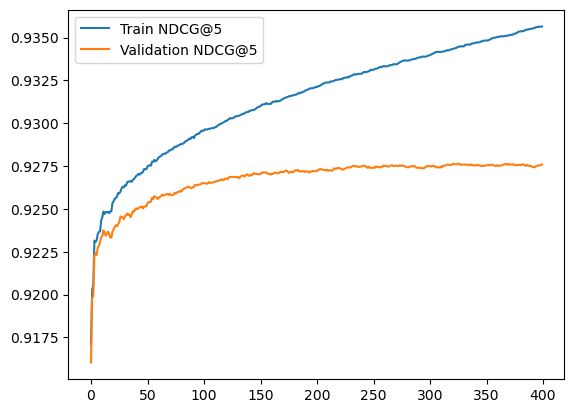

In [6]:
train_ndcg = evals_result['validation_0']['ndcg@5']
val_ndcg = evals_result['validation_1']['ndcg@5']

plt.plot(train_ndcg, label='Train NDCG@5')
plt.plot(val_ndcg, label='Validation NDCG@5')
plt.legend()
plt.show()

In [7]:
# Predict relevance scores on the validation set
y_pred = ranker.predict(X_val)

# Calculate NDCG@5 (normalized discounted cumulative gain at rank 5)
ndcg_at_5 = ndcg_score([y_val], [y_pred], k=5)

print(f'NDCG@5 on Validation Set: {ndcg_at_5}')

NDCG@5 on Validation Set: 0.6608397947263838


## Predict and Save test results

In [8]:
test_df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,price_usd_norm,prop_starrating_norm
0,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,3180,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.268703,1.0
1,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,5543,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.258042,1.0
2,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,14142,2,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522407,1.0
3,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,22393,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.524576,1.0
4,1,2013-02-02 15:27:40,24,216,3.374933,177.15073,219,24194,3,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842248,1.0


In [9]:
# Process the test data (apply same transformations as for train data)
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['month'] = test_df['date_time'].dt.month
test_df = test_df.drop(columns=['date_time'])

# Make predictions using the trained ranker model
y_pred = ranker.predict(test_df)

In [10]:
# Add predictions to the test data for ranking purposes
test_df['predicted_relevance'] = y_pred

# Sort the predictions by srch_id and predicted relevance (higher relevance first)
test_df_sorted = test_df.sort_values(by=['srch_id', 'predicted_relevance'], ascending=[True, False])

# Generate the submission file: srch_id, prop_id (top-ranked properties for each search)
submission = test_df_sorted[['srch_id', 'prop_id']]

# Save the submission file in the required format
submission.to_csv('submission.csv', index=False)